In [1]:
import os
import pandas as pd
import numpy as np
from scipy import stats
from IPython.display import display
import seaborn as sns

In [2]:
from glob import glob


def parse_energy_file(file_path):
    metrics = {}
    with open(file_path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                parts = line.split()
                if len(parts) < 2:
                    continue
                
                full_metric = parts[0]
                value = float(parts[-1])
                
                if "{" in full_metric and "}" in full_metric:
                    metric_name = full_metric.split("{")[0]
                    labels = full_metric.split("{")[1].split("}")[0]
                    
                    if "mode=" in labels:
                        mode = labels.split("mode=")[1].split(",")[0].strip('"')
                        key = f"{metric_name}_{mode}"
                    else:
                        key = metric_name
                else:
                    key = full_metric
                
                metrics[key] = value
            except (IndexError, ValueError) as e:
                print(f"Error parsing line '{line}': {str(e)}")
                continue
    return metrics


def calculate_energy_consumption(before_metrics, after_metrics):
    if not before_metrics or not after_metrics:
        return None

    total_joules_key = "kepler_container_joules_total_dynamic"

    dynamic_key = f'{total_joules_key}'
    if dynamic_key in after_metrics and dynamic_key in before_metrics:
        total_energy = after_metrics[dynamic_key] - before_metrics[dynamic_key]
    else:
        return None

    return total_energy if total_energy >= 0 else None
def calculate_cpu_usage_time(before_metrics, after_metrics):
    if not before_metrics or not after_metrics:
        return None

    cpu_usage_key = "kepler_container_bpf_cpu_time_ms_total"

    if cpu_usage_key in after_metrics and cpu_usage_key in before_metrics:
        total_cpu_time = after_metrics[cpu_usage_key] - before_metrics[cpu_usage_key]
    else:
        return None

    return total_cpu_time if total_cpu_time >= 0 else None

def process_test_directory(base_dir, test_name, requests, gateway=False):
    """Process all report directories for a specific test case."""
    energy_consumptions = []
    cpu_time_consumptions = []

    # Determine the path pattern based on whether it's gateway or not
    path_pattern = os.path.join(base_dir, str(requests), "report_*")

    # Process each report directory
    for report_dir in glob(path_pattern):
        try:
            before_file_gateway = None
            after_file_gateway = None
            before_metrics_gateway = None
            after_metrics_gateway = None
            energy_gateway = 0
            
            if gateway:
                before_file_gateway = os.path.join(report_dir, "before_gateway.txt")
                after_file_gateway = os.path.join(report_dir, "after_gateway.txt")
                
            before_file = os.path.join(report_dir, "before.txt")
            after_file = os.path.join(report_dir, "after.txt")

            if os.path.exists(before_file) and os.path.exists(after_file):
                if gateway and os.path.exists(before_file_gateway) and os.path.exists(after_file_gateway):
                    before_metrics_gateway = parse_energy_file(before_file_gateway)
                    after_metrics_gateway = parse_energy_file(after_file_gateway)
                    energy_gateway = calculate_energy_consumption(
                        before_metrics_gateway, after_metrics_gateway
                    )
                
                
                before_metrics = parse_energy_file(before_file)
                after_metrics = parse_energy_file(after_file)
                energy = calculate_energy_consumption(before_metrics, after_metrics)
                cpu_time = calculate_cpu_usage_time(before_metrics, after_metrics)
                if energy is not None:
                    energy_consumptions.append(energy + energy_gateway)
                if cpu_time is not None:
                    cpu_time_consumptions.append(cpu_time)
        except Exception as e:
            print(f"Error processing {report_dir}: {str(e)}")
            continue

    if not energy_consumptions:
        return None
    if not cpu_time_consumptions:
        return None
    # Pearson correlation coefficient
    if len(energy_consumptions) != len(cpu_time_consumptions):
        print(f"Warning: Mismatched lengths for energy and CPU time in {test_name} with {requests} requests.")
        return None
    res = stats.spearmanr(cpu_time_consumptions, energy_consumptions, alternative='greater')
    
    mean_value = np.mean(energy_consumptions)
    std_value = np.std(energy_consumptions)
    ste_value = std_value / np.sqrt(len(energy_consumptions))
    rsd = (std_value / mean_value) * 100 if mean_value != 0 else 0
    rse = (ste_value / mean_value) * 100 if mean_value != 0 else 0


    # Calculate statistics
    statistics = {
        "Test": test_name,
        "Requests": requests,
        "Mean": round(np.mean(energy_consumptions), 2),
        "Med": round(np.median(energy_consumptions), 2),
        "Min": round(np.min(energy_consumptions), 2),
        "Max": round(np.max(energy_consumptions), 2),
        "Std": round(np.std(energy_consumptions), 2),
        "RSD (%)": round(rsd, 2),
        "RSE (%)": round(rse, 2),
        "CPU Time (ms)": round(np.mean(cpu_time_consumptions), 2),
        "Monotonic relationship p-value":  round(res.pvalue, 6),
        "Monotonic relationship coefficient": round(res.correlation, 4),
        
        
    }

    return statistics,energy_consumptions, cpu_time_consumptions


def get_endpoint_name(path):
    """Extract endpoint name from path"""
    parts = path.split("/")
    # Look for parts like 'json_get_user_id' or 'protobuf_get_all_users'
    for part in parts:
        if part.startswith("json_") or part.startswith("protobuf_"):
            return part.replace("json_", "").replace("protobuf_", "")
    return "unknown_endpoint"


def custom_sort(row):
    """Custom sorting function for the desired order"""
    test = row["Test"]
    requests = row["Requests"]

    if "Gateway" not in test:
        if requests == 1000:
            return 0 if "JSON" in test else 1
        else:
            return 2 if "JSON" in test else 3
    else:
        if requests == 1000:
            return 4 if "JSON" in test else 5
        else:
            return 6 if "JSON" in test else 7


test_dirs = [
    "../Control_Project_JSON/k6/json_get_all_products_entities/reports/json_get_all_products_entities",
    "../Control_Project_JSON/k6/json_get_user_id/reports/json_get_user_id",
    "../Control_Project_JSON/k6/json_get_all_users/reports/json_get_all_users",
    "../Control_Project_JSON/k6/json_create_user/reports/json_create_user",
    "../Control_Project_JSON/k6/json_update_user/reports/json_update_user",
    "../Control_Project_JSON/k6/json_delete_user/reports/json_delete_user",
    "../Experimental_Group_ProtoBuff/k6/protobuf_get_all_products_entities/reports/protobuf_get_all_products_entities",
    "../Experimental_Group_ProtoBuff/k6/protobuf_get_user_id/reports/protobuf_get_user_id",
    "../Experimental_Group_ProtoBuff/k6/protobuf_get_all_users/reports/protobuf_get_all_users",
    "../Experimental_Group_ProtoBuff/k6/protobuf_create_user/reports/protobuf_create_user",
    "../Experimental_Group_ProtoBuff/k6/protobuf_update_user/reports/protobuf_update_user",
    "../Experimental_Group_ProtoBuff/k6/protobuf_delete_user/reports/protobuf_delete_user",
    "../Gateway/k6_json/json_get_all_products_entities/reports/json_get_all_products_entities_gateway",
    "../Gateway/k6_json/json_get_user_id/reports/json_get_user_id_gateway",
    "../Gateway/k6_json/json_get_all_users/reports/json_get_all_users_gateway",
    "../Gateway/k6_json/json_create_user/reports/json_create_user_gateway",
    "../Gateway/k6_json/json_update_user/reports/json_update_user_gateway",
    "../Gateway/k6_json/json_delete_user/reports/json_delete_user_gateway",
    "../Gateway/k6_protobuf/protobuf_get_all_products_entities/reports/protobuf_get_all_products_entities_gateway",
    "../Gateway/k6_protobuf/protobuf_get_user_id/reports/protobuf_get_user_id_gateway",
    "../Gateway/k6_protobuf/protobuf_get_all_users/reports/protobuf_get_all_users_gateway",
    "../Gateway/k6_protobuf/protobuf_create_user/reports/protobuf_create_user_gateway",
    "../Gateway/k6_protobuf/protobuf_update_user/reports/protobuf_update_user_gateway",
    "../Gateway/k6_protobuf/protobuf_delete_user/reports/protobuf_delete_user_gateway",
]

# Group by endpoint
endpoint_data = {}

for test_dir in test_dirs:
    if not os.path.exists(test_dir):
        print(f"Directory not found: {test_dir}")
        continue

    # Determine endpoint name, test type, and whether it's gateway
    endpoint = get_endpoint_name(test_dir)
    is_gateway = "Gateway" in test_dir
    is_protobuf = "protobuf" in test_dir.lower()

    test_type = "PROTOBUF" if is_protobuf else "JSON"
    if is_gateway:
        test_type += " + Gateway"

    # Process for both request counts
    for requests in [1000, 10000]:
        statistics,_,_ = process_test_directory(test_dir, test_type, requests, is_gateway)
        if statistics:
            if endpoint not in endpoint_data:
                endpoint_data[endpoint] = []
            endpoint_data[endpoint].append(statistics)

# Print results for each endpoint
for endpoint, results in endpoint_data.items():
    df = pd.DataFrame(results)

    # Add sorting key and sort
    df["sort_key"] = df.apply(custom_sort, axis=1)
    df = df.sort_values("sort_key").drop("sort_key", axis=1)

    df = df[
        [
            "Test",
            "Requests",
            "Mean",
            "Med",
            "Min",
            "Max",
            "Std",
            "RSD (%)",
            "RSE (%)",
            "CPU Time (ms)",
            "Monotonic relationship p-value",
            "Monotonic relationship coefficient",
        ]
    ]

    print(
        f"\nEnergy Consumption Statistics for {endpoint.replace('_', ' ').title()} (Joules):"
    )
    display(df)

    comparisons = []
    for (is_gateway, req_count), group in df.groupby([df["Test"].str.contains("Gateway"), "Requests"]):
        if len(group) == 2:  
            json_row = group[group["Test"].str.contains("JSON")].iloc[0]
            proto_row = group[group["Test"].str.contains("PROTOBUF")].iloc[0]

            test_name = "PROTOBUF + Gateway vs JSON + Gateway" if is_gateway else "PROTOBUF vs JSON"
            diff_pcts = {
                "Test": f"{test_name} ({req_count} requests)",
                "Mean %": (
                    (json_row["Mean"] - proto_row["Mean"]) / json_row["Mean"]
                )
                * 100,
                "Median %": ((json_row["Med"] - proto_row["Med"]) / json_row["Med"])
                * 100,
                "Min %": ((json_row["Min"] - proto_row["Min"]) / json_row["Min"])
                * 100,  
                "Max %": ((json_row["Max"] - proto_row["Max"]) / json_row["Max"])
                * 100,
                "Std %": ((json_row["Std"] - proto_row["Std"]) / json_row["Std"])
                * 100,
            }
            comparisons.append(diff_pcts)

    # Create comparison table
    comparison_df = pd.DataFrame(comparisons)
    comparison_df = comparison_df.round(2)  # Round to 2 decimal places

    print(f"\nPercentage Comparison for {endpoint.replace('_', ' ').title()}:")
    display(comparison_df)


Energy Consumption Statistics for Get All Products Entities (Joules):


,Test,Requests,Mean,Med,Min,Max,Std,RSD (%),RSE (%),CPU Time (ms),Monotonic relationship p-value,Monotonic relationship coefficient
0,JSON,1000,22.91,15.23,4.42,97.59,26.17,114.22,36.12,3566.9,0.000000,1.0000
2,PROTOBUF,1000,18.66,18.03,3.64,58.89,14.52,77.83,24.61,2924.6,0.000000,0.9879
1,JSON,10000,80.19,81.05,73.85,84.59,3.68,4.58,1.45,10854.7,0.000000,0.9879
3,PROTOBUF,10000,73.12,72.82,69.49,80.28,3.11,4.25,1.34,9825.8,0.000027,0.9394
4,JSON + Gateway,1000,51.29,40.06,8.19,178.66,44.67,87.10,27.54,3850.3,0.000000,1.0000
6,PROTOBUF + Gateway,1000,31.78,28.89,5.61,72.88,17.34,54.57,17.26,3248.3,0.000001,0.9758
5,JSON + Gateway,10000,216.30,215.75,203.97,232.72,9.38,4.34,1.37,13451.1,0.000000,0.9879
7,PROTOBUF + Gateway,10000,204.99,208.63,192.83,211.87,6.74,3.29,1.04,12246.5,0.000000,1.0000



Percentage Comparison for Get All Products Entities:


,Test,Mean %,Median %,Min %,Max %,Std %
0,PROTOBUF vs JSON (1000 requests),18.55,-18.38,17.65,39.66,44.52
1,PROTOBUF vs JSON (10000 requests),8.82,10.15,5.90,5.10,15.49
2,PROTOBUF + Gateway vs JSON + Gateway (1000 req...,38.04,27.88,31.50,59.21,61.18
3,PROTOBUF + Gateway vs JSON + Gateway (10000 re...,5.23,3.30,5.46,8.96,28.14



Energy Consumption Statistics for Get User Id (Joules):


,Test,Requests,Mean,Med,Min,Max,Std,RSD (%),RSE (%),CPU Time (ms),Monotonic relationship p-value,Monotonic relationship coefficient
0,JSON,1000,4.09,1.54,0.01,20.99,6.04,147.67,46.70,716.5,0.000000,1.0000
2,PROTOBUF,1000,2.72,1.00,0.00,11.09,3.51,129.02,40.80,470.7,0.000000,1.0000
1,JSON,10000,45.77,43.83,42.66,52.51,3.67,8.02,2.54,6158.2,0.000000,0.9848
3,PROTOBUF,10000,44.78,44.65,43.56,46.90,1.09,2.44,0.77,5903.9,0.000000,0.9848
4,JSON + Gateway,1000,15.19,16.14,4.09,34.00,8.86,58.33,18.44,1035.0,0.000000,1.0000
6,PROTOBUF + Gateway,1000,11.02,9.31,0.08,24.80,8.18,74.24,23.48,836.8,0.000000,0.9879
5,JSON + Gateway,10000,176.57,175.52,167.85,185.87,5.48,3.11,0.98,8724.3,0.001907,0.8182
7,PROTOBUF + Gateway,10000,167.19,166.36,159.02,173.32,3.89,2.33,0.74,8197.4,0.000172,0.9030



Percentage Comparison for Get User Id:


,Test,Mean %,Median %,Min %,Max %,Std %
0,PROTOBUF vs JSON (1000 requests),33.50,35.06,100.00,47.17,41.89
1,PROTOBUF vs JSON (10000 requests),2.16,-1.87,-2.11,10.68,70.30
2,PROTOBUF + Gateway vs JSON + Gateway (1000 req...,27.45,42.32,98.04,27.06,7.67
3,PROTOBUF + Gateway vs JSON + Gateway (10000 re...,5.31,5.22,5.26,6.75,29.01



Energy Consumption Statistics for Get All Users (Joules):


,Test,Requests,Mean,Med,Min,Max,Std,RSD (%),RSE (%),CPU Time (ms),Monotonic relationship p-value,Monotonic relationship coefficient
0,JSON,1000,9.82,8.72,0.49,26.45,8.06,82.04,25.94,1225.2,0.000000,1.0000
2,PROTOBUF,1000,5.03,3.67,0.01,15.10,4.88,96.98,30.67,744.0,0.000000,0.9879
1,JSON,10000,148.21,146.55,139.19,160.62,6.04,4.07,1.29,15048.4,0.000000,0.9879
3,PROTOBUF,10000,85.19,85.25,81.83,89.40,2.60,3.05,0.96,10523.1,0.000056,0.9273
4,JSON + Gateway,1000,22.59,24.82,8.55,43.87,10.42,46.11,14.58,1589.9,0.000000,1.0000
6,PROTOBUF + Gateway,1000,17.05,17.01,5.45,36.93,9.36,54.91,17.36,1269.1,0.000004,0.9636
5,JSON + Gateway,10000,299.08,296.85,288.67,314.13,8.08,2.70,0.85,17232.2,0.000001,0.9758
7,PROTOBUF + Gateway,10000,233.97,235.49,223.41,240.92,5.52,2.36,0.75,12854.7,0.000011,0.9515



Percentage Comparison for Get All Users:


,Test,Mean %,Median %,Min %,Max %,Std %
0,PROTOBUF vs JSON (1000 requests),48.78,57.91,97.96,42.91,39.45
1,PROTOBUF vs JSON (10000 requests),42.52,41.83,41.21,44.34,56.95
2,PROTOBUF + Gateway vs JSON + Gateway (1000 req...,24.52,31.47,36.26,15.82,10.17
3,PROTOBUF + Gateway vs JSON + Gateway (10000 re...,21.77,20.67,22.61,23.31,31.68



Energy Consumption Statistics for Create User (Joules):


,Test,Requests,Mean,Med,Min,Max,Std,RSD (%),RSE (%),CPU Time (ms),Monotonic relationship p-value,Monotonic relationship coefficient
0,JSON,1000,357.34,355.49,347.80,376.66,7.49,2.10,0.66,61447.0,0.000027,0.9394
2,PROTOBUF,1000,360.65,361.20,347.88,372.82,6.28,1.74,0.55,60850.7,0.000011,0.9515
1,JSON,10000,4300.34,4304.18,3672.11,4801.95,364.30,8.47,2.68,735620.4,0.000000,1.0000
3,PROTOBUF,10000,4361.49,4339.10,3694.91,5082.16,438.69,10.06,3.18,735896.2,0.000000,1.0000
4,JSON + Gateway,1000,378.33,374.33,369.33,399.14,8.47,2.24,0.71,61295.8,0.000407,0.8788
6,PROTOBUF + Gateway,1000,379.03,378.17,375.56,388.72,3.62,0.96,0.30,61296.7,0.000196,0.8997
5,JSON + Gateway,10000,4525.71,4582.42,3865.06,5026.46,398.85,8.81,2.79,738676.6,0.000000,0.9879
7,PROTOBUF + Gateway,10000,4538.43,4577.74,3844.18,5111.56,412.31,9.08,2.87,737844.6,0.000000,1.0000



Percentage Comparison for Create User:


,Test,Mean %,Median %,Min %,Max %,Std %
0,PROTOBUF vs JSON (1000 requests),-0.93,-1.61,-0.02,1.02,16.15
1,PROTOBUF vs JSON (10000 requests),-1.42,-0.81,-0.62,-5.84,-20.42
2,PROTOBUF + Gateway vs JSON + Gateway (1000 req...,-0.19,-1.03,-1.69,2.61,57.26
3,PROTOBUF + Gateway vs JSON + Gateway (10000 re...,-0.28,0.10,0.54,-1.69,-3.37



Energy Consumption Statistics for Update User (Joules):


,Test,Requests,Mean,Med,Min,Max,Std,RSD (%),RSE (%),CPU Time (ms),Monotonic relationship p-value,Monotonic relationship coefficient
0,JSON,1000,73.30,73.15,67.17,79.58,3.97,5.42,1.71,12962.2,0.000000,0.9879
2,PROTOBUF,1000,76.30,76.40,73.37,79.88,1.98,2.60,0.82,13093.3,0.000172,0.9030
1,JSON,10000,763.24,760.76,753.38,775.94,8.04,1.05,0.33,130348.5,0.001470,0.8303
3,PROTOBUF,10000,812.03,814.23,786.99,829.51,12.67,1.56,0.49,133438.2,0.000027,0.9394
4,JSON + Gateway,1000,88.89,87.22,79.57,101.25,7.20,8.10,2.56,13245.9,0.000000,1.0000
6,PROTOBUF + Gateway,1000,89.15,88.83,82.02,97.82,4.39,4.93,1.56,13175.6,0.000004,0.9636
5,JSON + Gateway,10000,912.17,910.89,895.57,931.96,10.80,1.18,0.37,134092.8,0.002431,0.8061
7,PROTOBUF + Gateway,10000,945.42,943.21,925.31,964.15,12.04,1.27,0.40,137105.7,0.000056,0.9273



Percentage Comparison for Update User:


,Test,Mean %,Median %,Min %,Max %,Std %
0,PROTOBUF vs JSON (1000 requests),-4.09,-4.44,-9.23,-0.38,50.13
1,PROTOBUF vs JSON (10000 requests),-6.39,-7.03,-4.46,-6.90,-57.59
2,PROTOBUF + Gateway vs JSON + Gateway (1000 req...,-0.29,-1.85,-3.08,3.39,39.03
3,PROTOBUF + Gateway vs JSON + Gateway (10000 re...,-3.65,-3.55,-3.32,-3.45,-11.48



Energy Consumption Statistics for Delete User (Joules):


,Test,Requests,Mean,Med,Min,Max,Std,RSD (%),RSE (%),CPU Time (ms),Monotonic relationship p-value,Monotonic relationship coefficient
0,JSON,1000,66.71,65.31,59.62,74.98,5.56,8.34,2.64,11939.8,0.0,0.9879
2,PROTOBUF,1000,66.65,65.29,57.30,80.85,6.23,9.35,2.96,11686.0,0.0,0.9879
1,JSON,10000,364.71,345.18,85.83,660.38,178.45,48.93,15.47,62014.3,0.0,1.0000
3,PROTOBUF,10000,376.93,355.23,96.86,664.42,185.64,49.25,15.57,61522.4,0.0,1.0000
4,JSON + Gateway,1000,80.06,80.40,72.03,89.56,5.28,6.60,2.09,11959.9,0.0,0.9879
6,PROTOBUF + Gateway,1000,83.07,84.11,74.64,93.03,5.26,6.33,2.00,12373.0,0.0,0.9879
5,JSON + Gateway,10000,524.59,518.80,248.75,804.02,169.64,32.34,10.23,65430.5,0.0,1.0000
7,PROTOBUF + Gateway,10000,537.43,525.56,263.54,808.43,165.38,30.77,9.73,66685.7,0.0,1.0000



Percentage Comparison for Delete User:


,Test,Mean %,Median %,Min %,Max %,Std %
0,PROTOBUF vs JSON (1000 requests),0.09,0.03,3.89,-7.83,-12.05
1,PROTOBUF vs JSON (10000 requests),-3.35,-2.91,-12.85,-0.61,-4.03
2,PROTOBUF + Gateway vs JSON + Gateway (1000 req...,-3.76,-4.61,-3.62,-3.87,0.38
3,PROTOBUF + Gateway vs JSON + Gateway (10000 re...,-2.45,-1.30,-5.95,-0.55,2.51


In [3]:
from collections import defaultdict
from collections import namedtuple

TestResults = namedtuple("TestResults", ["name","values"])

id_to_paths = defaultdict(list)

test_dirs = {
    "../Control_Project_JSON/k6/json_get_all_products_entities/reports/json_get_all_products_entities": 1,
    "../Control_Project_JSON/k6/json_get_user_id/reports/json_get_user_id": 2,
    "../Control_Project_JSON/k6/json_get_all_users/reports/json_get_all_users": 3,
    "../Control_Project_JSON/k6/json_create_user/reports/json_create_user": 4,
    "../Control_Project_JSON/k6/json_update_user/reports/json_update_user": 5,
    "../Control_Project_JSON/k6/json_delete_user/reports/json_delete_user": 6,
    "../Experimental_Group_ProtoBuff/k6/protobuf_get_all_products_entities/reports/protobuf_get_all_products_entities": 1,
    "../Experimental_Group_ProtoBuff/k6/protobuf_get_user_id/reports/protobuf_get_user_id": 2,
    "../Experimental_Group_ProtoBuff/k6/protobuf_get_all_users/reports/protobuf_get_all_users": 3,
    "../Experimental_Group_ProtoBuff/k6/protobuf_create_user/reports/protobuf_create_user": 4,
    "../Experimental_Group_ProtoBuff/k6/protobuf_update_user/reports/protobuf_update_user": 5,
    "../Experimental_Group_ProtoBuff/k6/protobuf_delete_user/reports/protobuf_delete_user": 6,
    "../Gateway/k6_json/json_get_all_products_entities/reports/json_get_all_products_entities_gateway": 7,
    "../Gateway/k6_json/json_get_user_id/reports/json_get_user_id_gateway": 8,
    "../Gateway/k6_json/json_get_all_users/reports/json_get_all_users_gateway": 9,
    "../Gateway/k6_json/json_create_user/reports/json_create_user_gateway": 10,
    "../Gateway/k6_json/json_update_user/reports/json_update_user_gateway": 11,
    "../Gateway/k6_json/json_delete_user/reports/json_delete_user_gateway": 12,
    "../Gateway/k6_protobuf/protobuf_get_all_products_entities/reports/protobuf_get_all_products_entities_gateway": 7,
    "../Gateway/k6_protobuf/protobuf_get_user_id/reports/protobuf_get_user_id_gateway": 8,
    "../Gateway/k6_protobuf/protobuf_get_all_users/reports/protobuf_get_all_users_gateway": 9,
    "../Gateway/k6_protobuf/protobuf_create_user/reports/protobuf_create_user_gateway": 10,
    "../Gateway/k6_protobuf/protobuf_update_user/reports/protobuf_update_user_gateway": 11,
    "../Gateway/k6_protobuf/protobuf_delete_user/reports/protobuf_delete_user_gateway": 12,
}

for path, id in test_dirs.items():
    id_to_paths[id].append(path)

final_dict = defaultdict(lambda: defaultdict(list))

for id, test_dirs in id_to_paths.items():
    for test_dir in test_dirs:
        endpoint = get_endpoint_name(test_dir) 
        is_gateway = "Gateway" in test_dir
        is_protobuf = "protobuf" in test_dir.lower()
        test_type = "PROTOBUF" if is_protobuf else "JSON"
        if is_gateway:
            test_type += " + Gateway"
            endpoint += " + Gateway"
        for requests in [1000, 10000]:
            _, energy, _ = process_test_directory(  
                test_dir, test_type, requests
            )
            final_dict[id][requests].append(TestResults(name=endpoint, values=energy))



    # if not os.path.exists(test_dir):
    #     print(f"Directory not found: {test_dir}")
    #     continue

    # endpoint = get_endpoint_name(test_dir)
    # is_gateway = "Gateway" in test_dir
    # is_protobuf = "protobuf" in test_dir.lower()

    # test_type = "PROTOBUF" if is_protobuf else "JSON"
    # if is_gateway:
    #     test_type += " + Gateway"

    # for requests in [1000, 10000]:
    #     _, energy, _ = process_test_directory(
    #         test_dir, test_type, requests, is_gateway
    #     )

In [4]:
print(f"{final_dict}")

defaultdict(<function <lambda> at 0x000001EF9F5172E0>, {1: defaultdict(<class 'list'>, {1000: [TestResults(name='get_all_products_entities', values=[97.59300000000002, 4.41599999999994, 31.980000000000018, 16.640999999999963, 10.61099999999999, 21.956999999999994, 19.90199999999993, 5.838000000000079, 6.377999999999929, 13.815000000000055]), TestResults(name='get_all_products_entities', values=[58.889999999999986, 11.08800000000008, 18.491999999999962, 20.946000000000026, 18.48300000000006, 17.586000000000013, 18.980999999999995, 5.715000000000032, 12.803999999999974, 3.641999999999939])], 10000: [TestResults(name='get_all_products_entities', values=[84.58800000000008, 73.84500000000003, 82.92600000000004, 83.93399999999997, 81.80999999999995, 74.43299999999999, 77.22599999999989, 79.62000000000012, 80.29200000000014, 83.2170000000001]), TestResults(name='get_all_products_entities', values=[75.60900000000004, 69.93299999999999, 80.27699999999993, 74.46300000000008, 70.54199999999992, 7

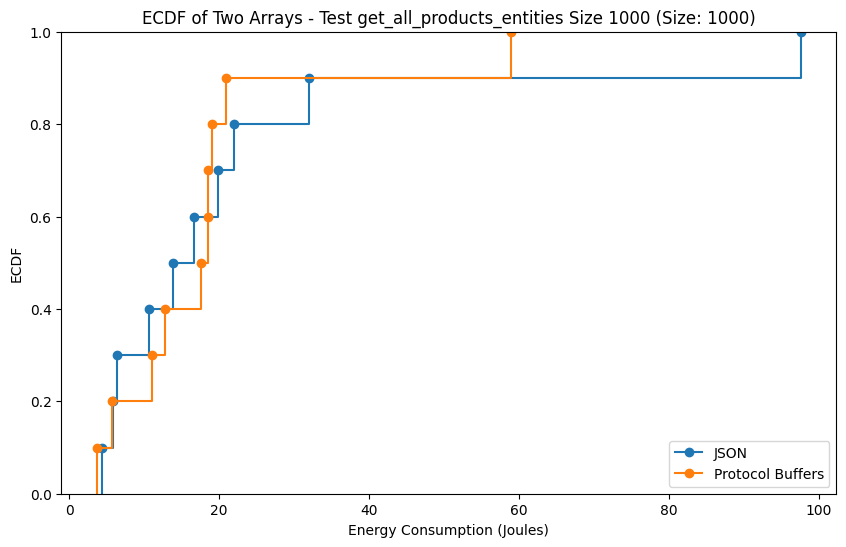

Bootstrap 95% CI for difference: [-17.18, 1.68]
get_all_products_entities - Probability Protocol Buffers < JSON: 83.8%
Bootstrap p-value: 0.8380
Conclusion: Fail to reject H0



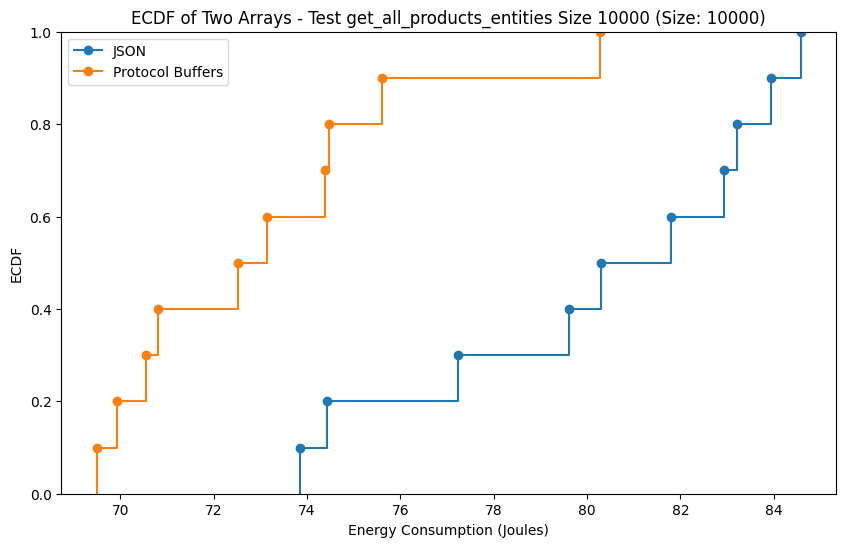

Bootstrap 95% CI for difference: [-9.02, -4.92]
get_all_products_entities - Probability Protocol Buffers < JSON: 100.0%
Bootstrap p-value: 1.0000
Conclusion: Fail to reject H0



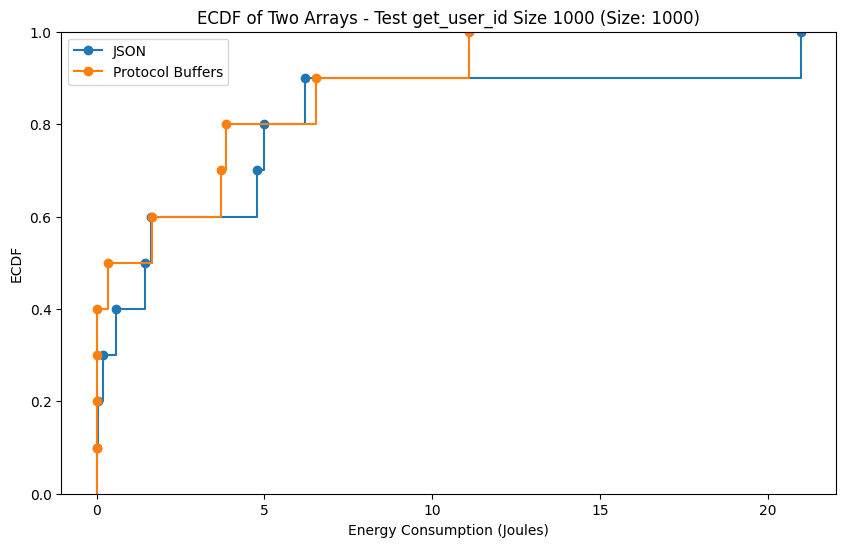

Bootstrap 95% CI for difference: [-4.34, 1.25]
get_user_id - Probability Protocol Buffers < JSON: 82.9%
Bootstrap p-value: 0.8289
Conclusion: Fail to reject H0



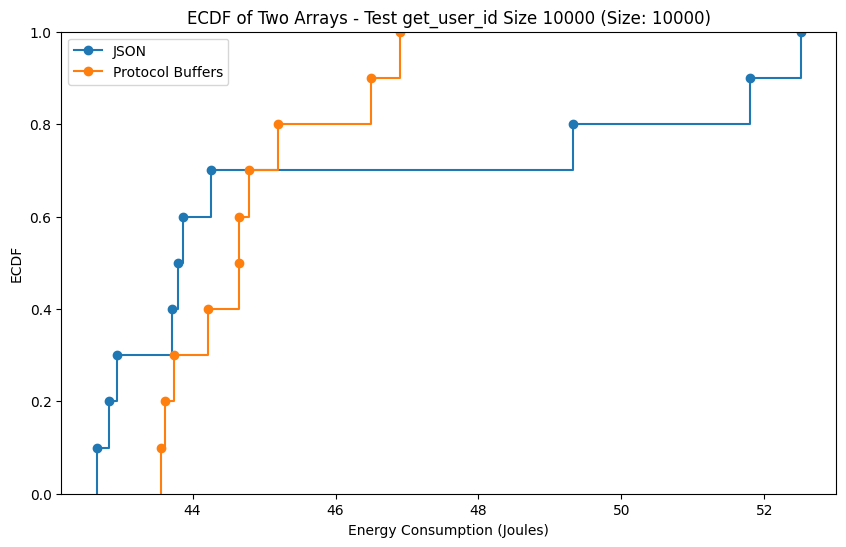

Bootstrap 95% CI for difference: [-3.87, 1.10]
get_user_id - Probability Protocol Buffers < JSON: 78.0%
Bootstrap p-value: 0.7798
Conclusion: Fail to reject H0



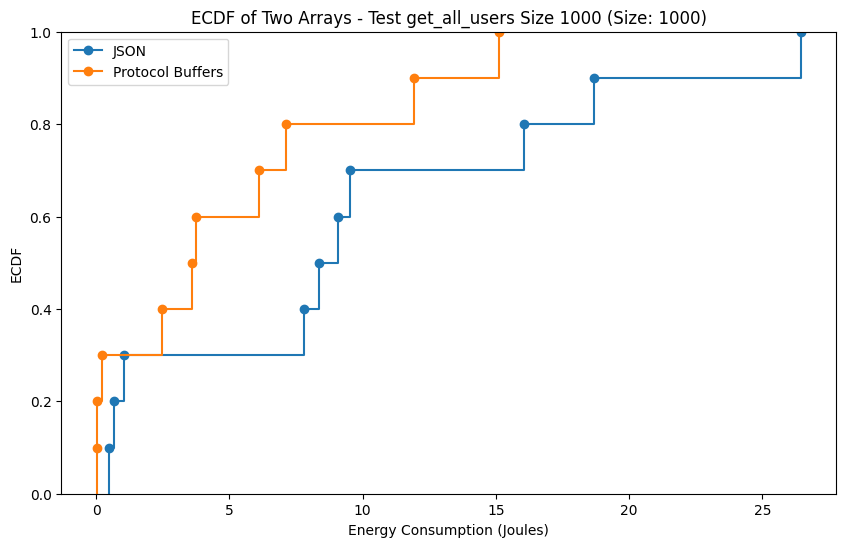

Bootstrap 95% CI for difference: [-8.61, -1.01]
get_all_users - Probability Protocol Buffers < JSON: 99.4%
Bootstrap p-value: 0.9939
Conclusion: Fail to reject H0



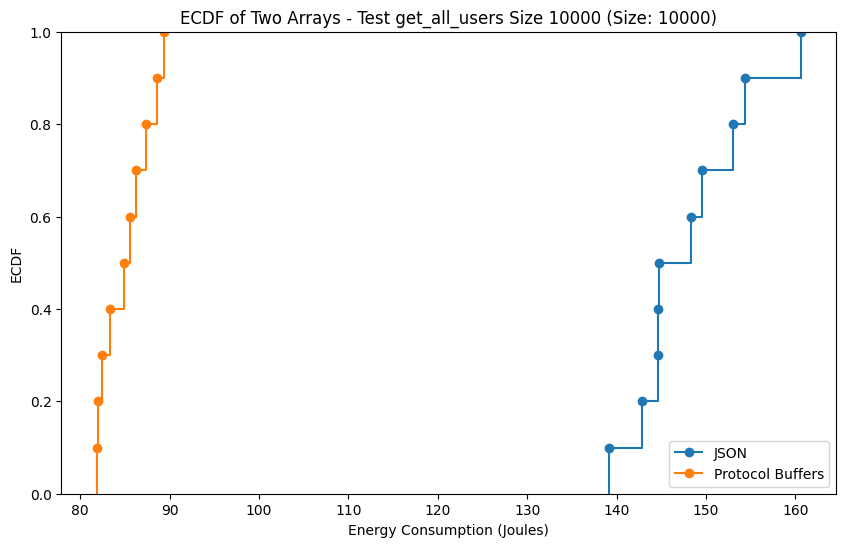

Bootstrap 95% CI for difference: [-67.39, -58.67]
get_all_users - Probability Protocol Buffers < JSON: 100.0%
Bootstrap p-value: 1.0000
Conclusion: Fail to reject H0



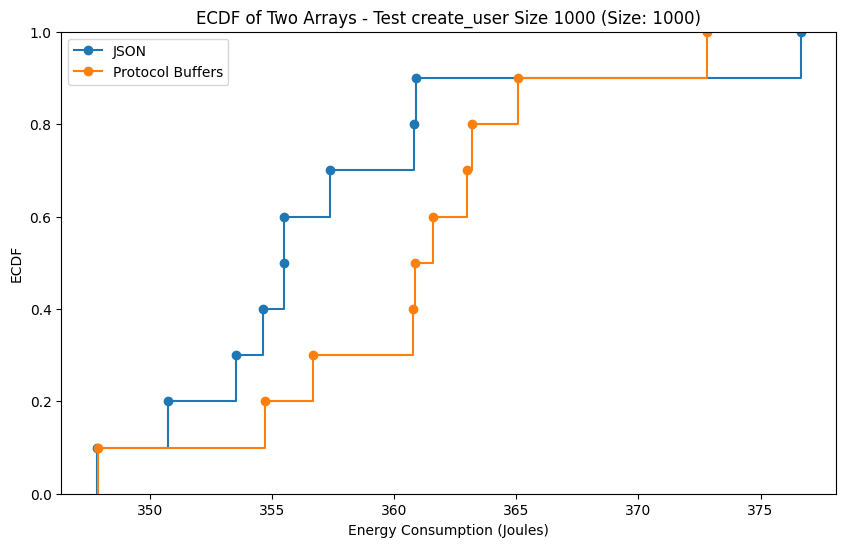

Bootstrap 95% CI for difference: [-0.47, 7.22]
create_user - Probability Protocol Buffers < JSON: 4.5%
Bootstrap p-value: 0.0446
Conclusion: Reject H0



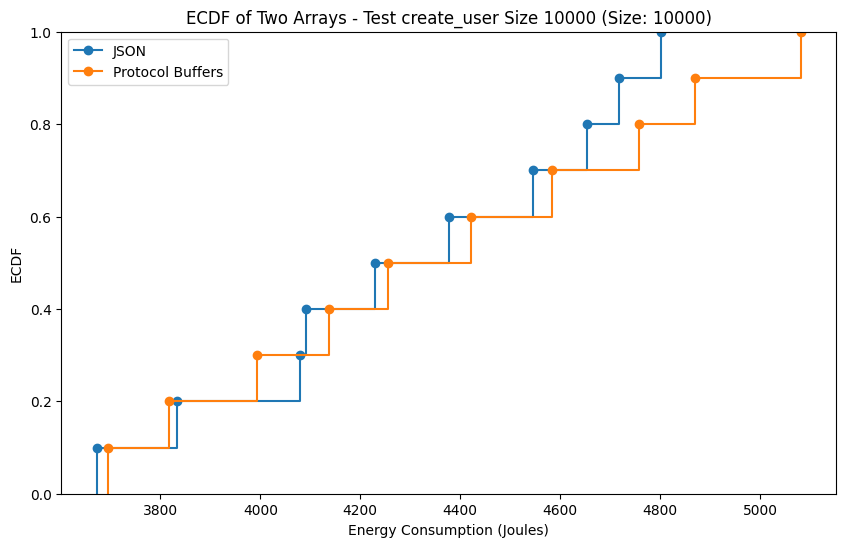

Bootstrap 95% CI for difference: [12.92, 132.85]
create_user - Probability Protocol Buffers < JSON: 1.1%
Bootstrap p-value: 0.0112
Conclusion: Reject H0



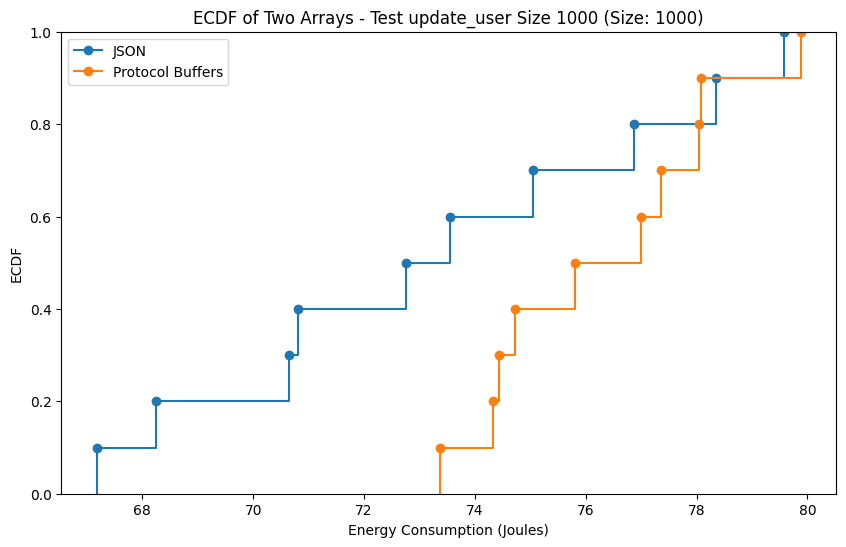

Bootstrap 95% CI for difference: [0.01, 5.22]
update_user - Probability Protocol Buffers < JSON: 1.5%
Bootstrap p-value: 0.0145
Conclusion: Reject H0



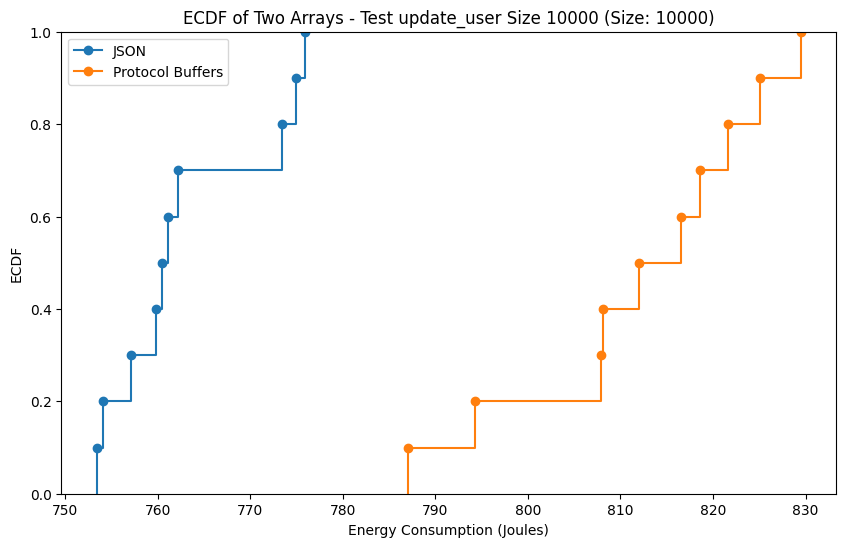

Bootstrap 95% CI for difference: [34.82, 58.07]
update_user - Probability Protocol Buffers < JSON: 0.0%
Bootstrap p-value: 0.0000
Conclusion: Reject H0



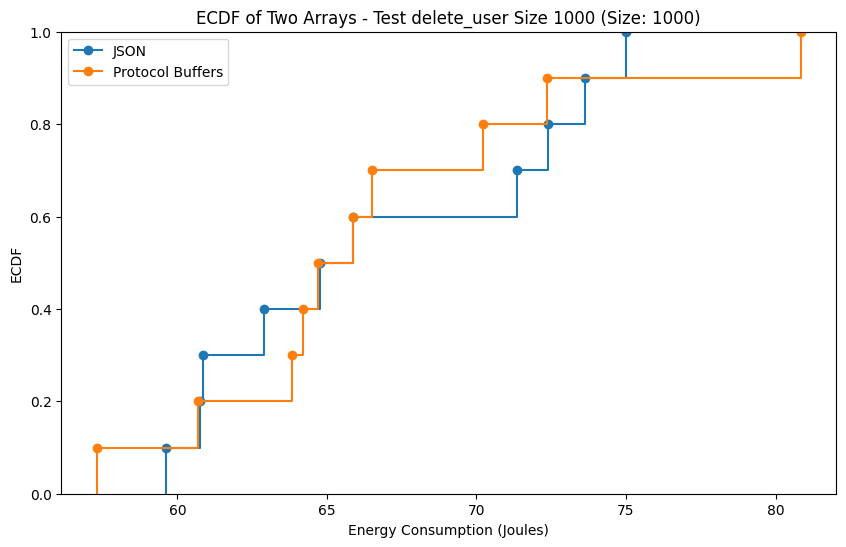

Bootstrap 95% CI for difference: [-4.01, 3.74]
delete_user - Probability Protocol Buffers < JSON: 51.3%
Bootstrap p-value: 0.5131
Conclusion: Fail to reject H0



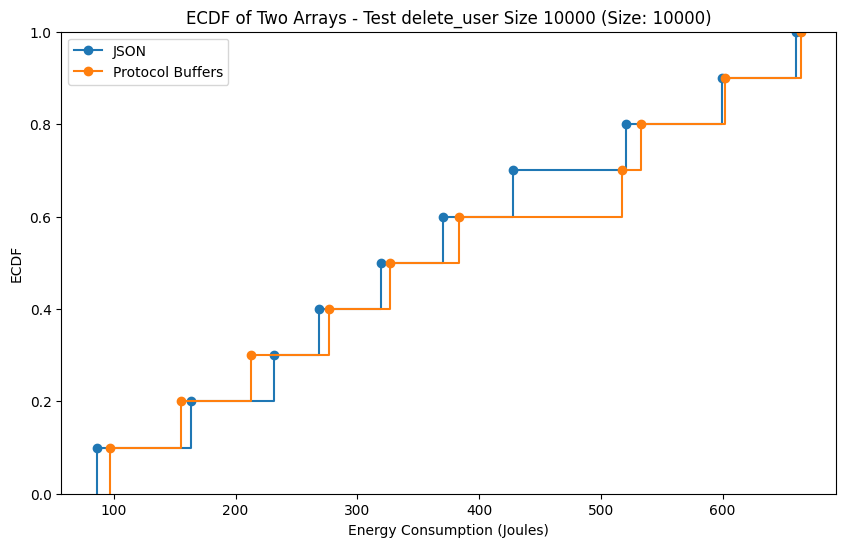

Bootstrap 95% CI for difference: [0.77, 40.78]
delete_user - Probability Protocol Buffers < JSON: 5.0%
Bootstrap p-value: 0.0496
Conclusion: Reject H0



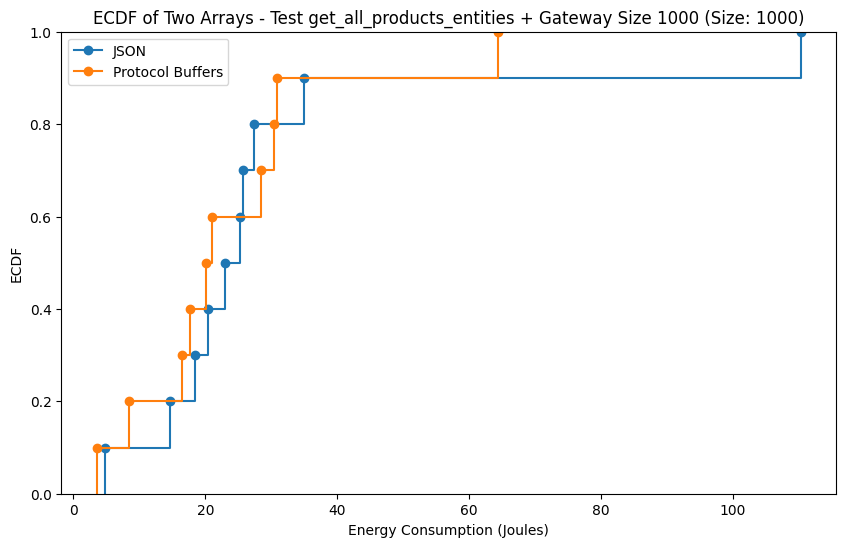

Bootstrap 95% CI for difference: [-20.91, -0.55]
get_all_products_entities + Gateway - Probability Protocol Buffers < JSON: 95.3%
Bootstrap p-value: 0.9528
Conclusion: Fail to reject H0



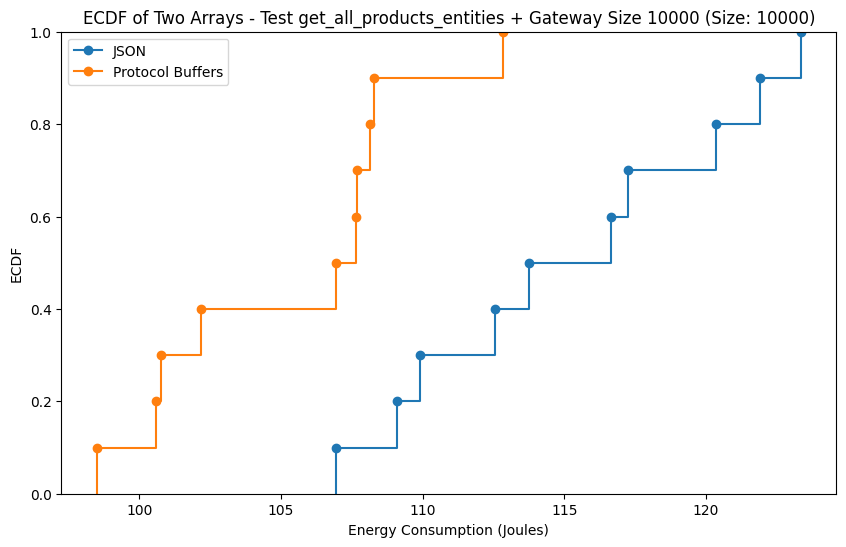

Bootstrap 95% CI for difference: [-13.11, -7.55]
get_all_products_entities + Gateway - Probability Protocol Buffers < JSON: 100.0%
Bootstrap p-value: 1.0000
Conclusion: Fail to reject H0



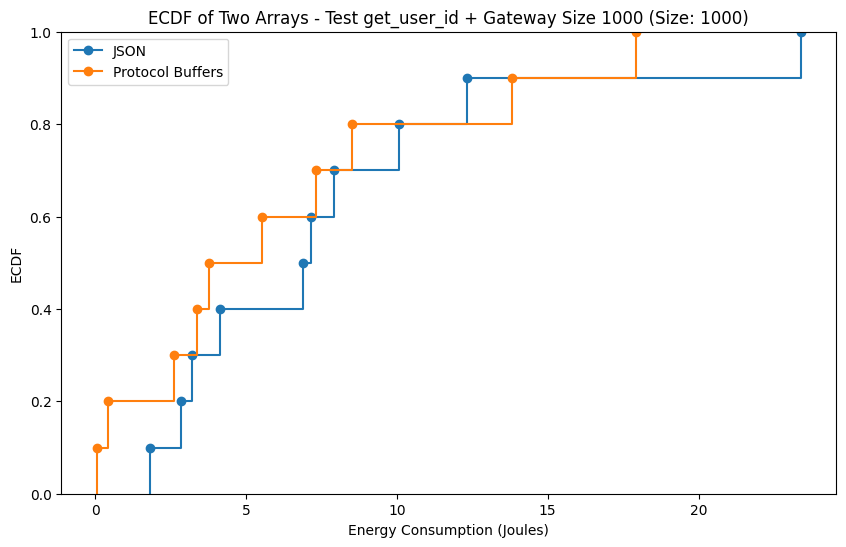

Bootstrap 95% CI for difference: [-3.17, 0.93]
get_user_id + Gateway - Probability Protocol Buffers < JSON: 94.0%
Bootstrap p-value: 0.9396
Conclusion: Fail to reject H0



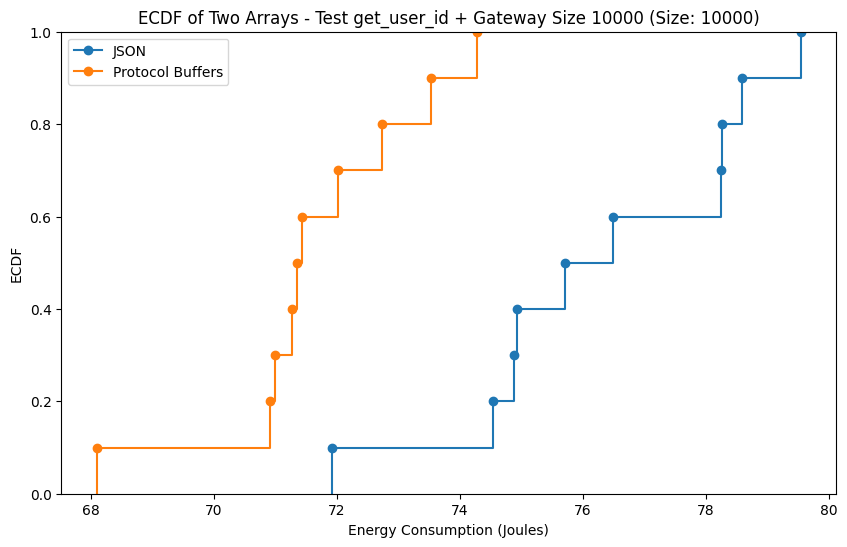

Bootstrap 95% CI for difference: [-6.55, -2.81]
get_user_id + Gateway - Probability Protocol Buffers < JSON: 100.0%
Bootstrap p-value: 1.0000
Conclusion: Fail to reject H0



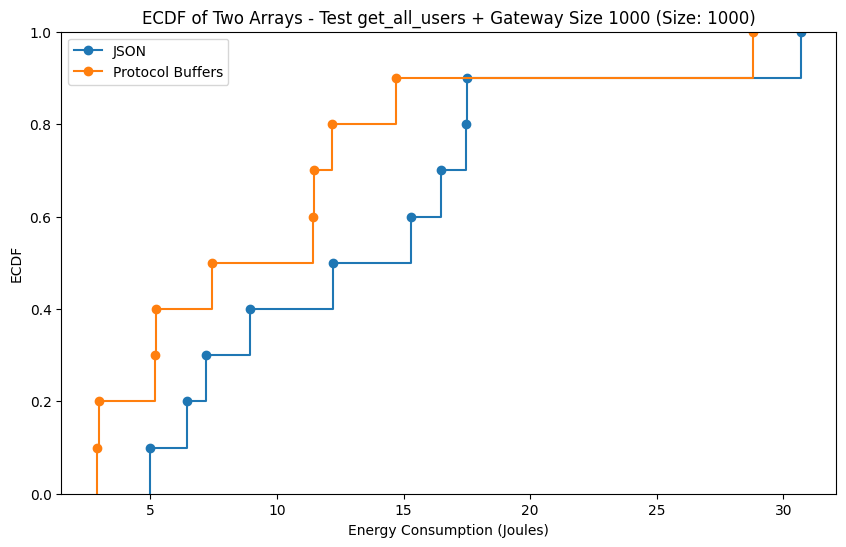

Bootstrap 95% CI for difference: [-7.15, -0.15]
get_all_users + Gateway - Probability Protocol Buffers < JSON: 97.6%
Bootstrap p-value: 0.9759
Conclusion: Fail to reject H0



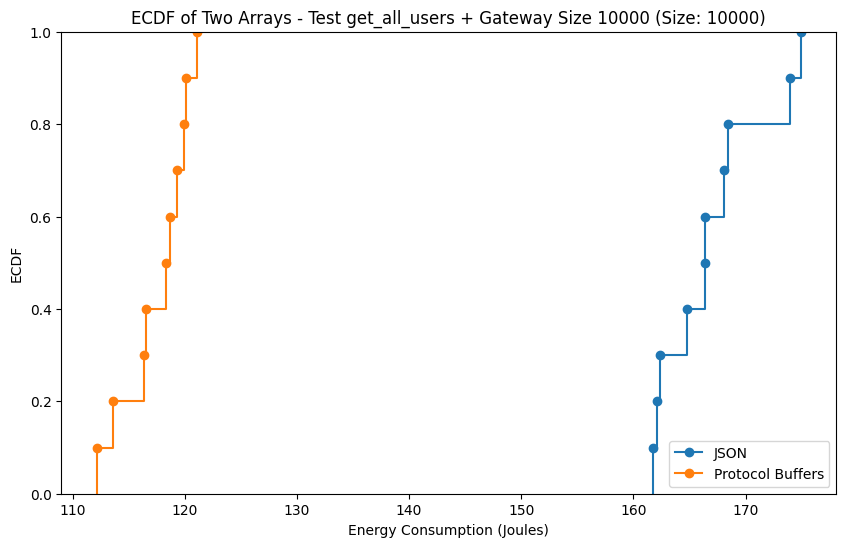

Bootstrap 95% CI for difference: [-52.33, -46.11]
get_all_users + Gateway - Probability Protocol Buffers < JSON: 100.0%
Bootstrap p-value: 1.0000
Conclusion: Fail to reject H0



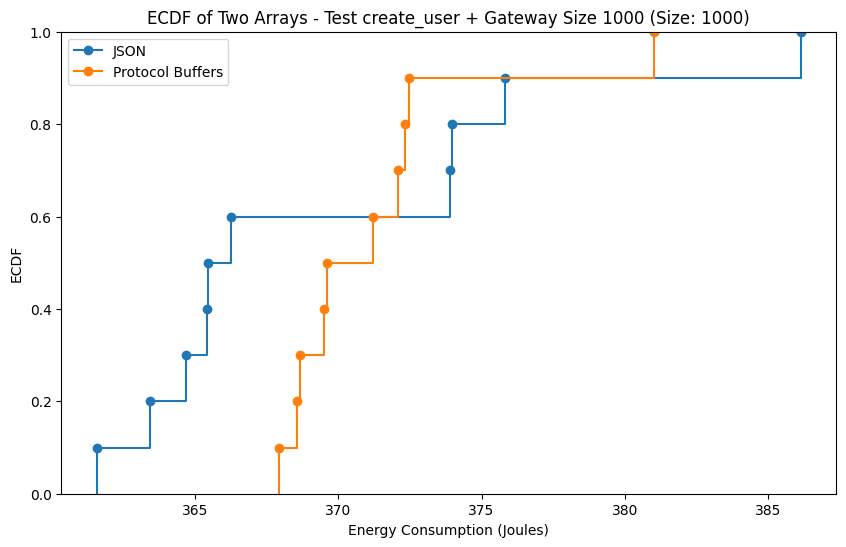

Bootstrap 95% CI for difference: [-2.20, 5.46]
create_user + Gateway - Probability Protocol Buffers < JSON: 20.2%
Bootstrap p-value: 0.2019
Conclusion: Fail to reject H0



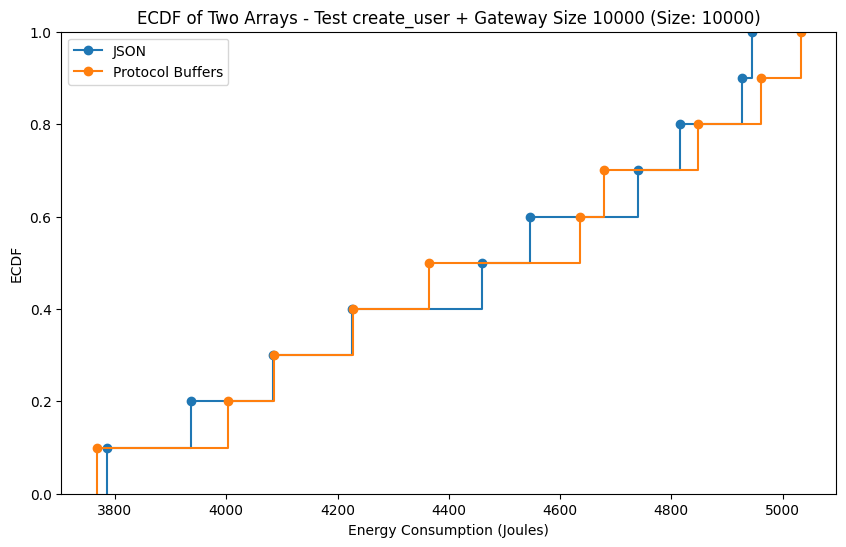

Bootstrap 95% CI for difference: [-24.75, 50.02]
create_user + Gateway - Probability Protocol Buffers < JSON: 22.7%
Bootstrap p-value: 0.2271
Conclusion: Fail to reject H0



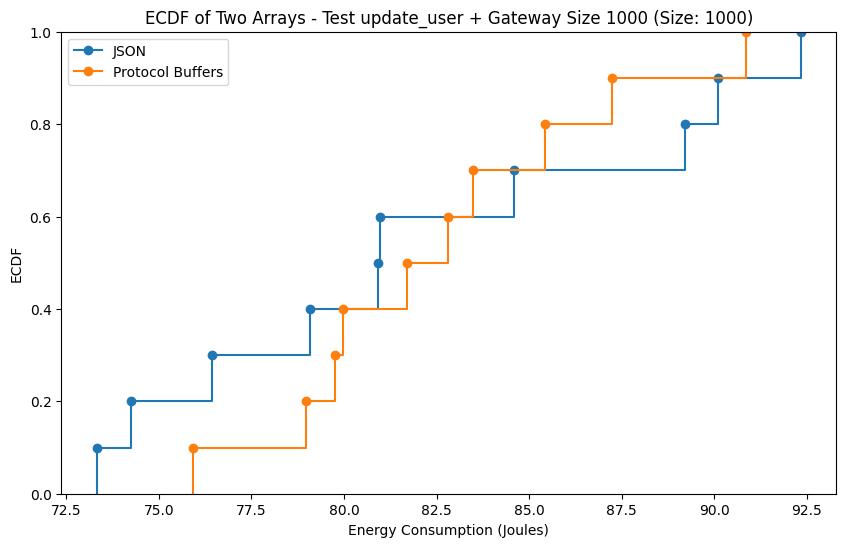

Bootstrap 95% CI for difference: [-3.01, 4.51]
update_user + Gateway - Probability Protocol Buffers < JSON: 40.7%
Bootstrap p-value: 0.4074
Conclusion: Fail to reject H0



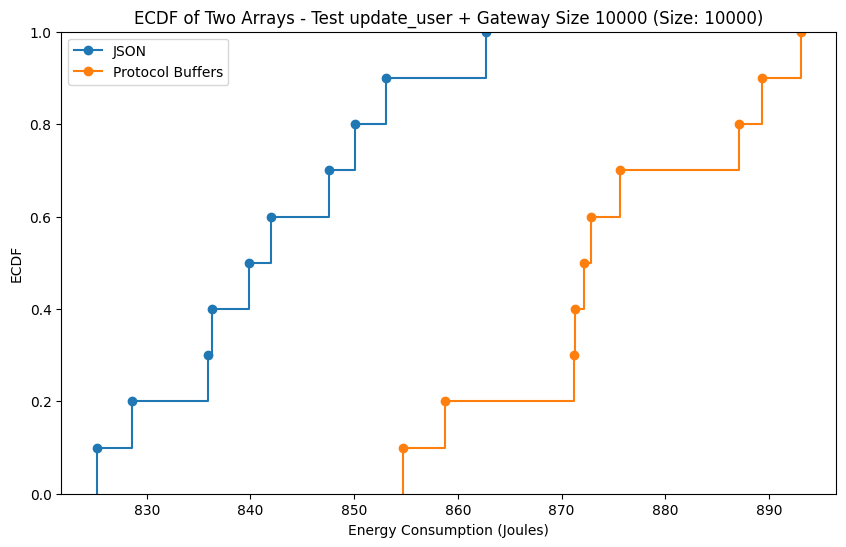

Bootstrap 95% CI for difference: [23.11, 43.28]
update_user + Gateway - Probability Protocol Buffers < JSON: 0.0%
Bootstrap p-value: 0.0000
Conclusion: Reject H0



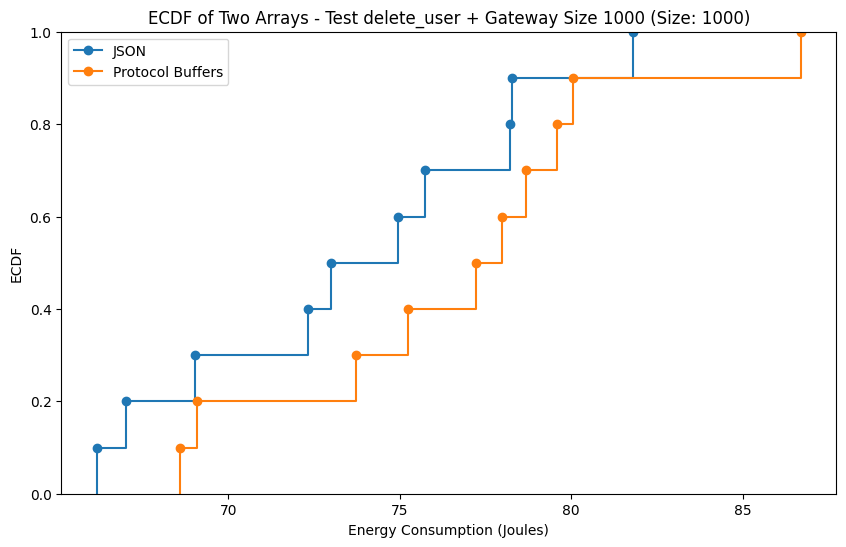

Bootstrap 95% CI for difference: [0.68, 6.06]
delete_user + Gateway - Probability Protocol Buffers < JSON: 0.8%
Bootstrap p-value: 0.0075
Conclusion: Reject H0



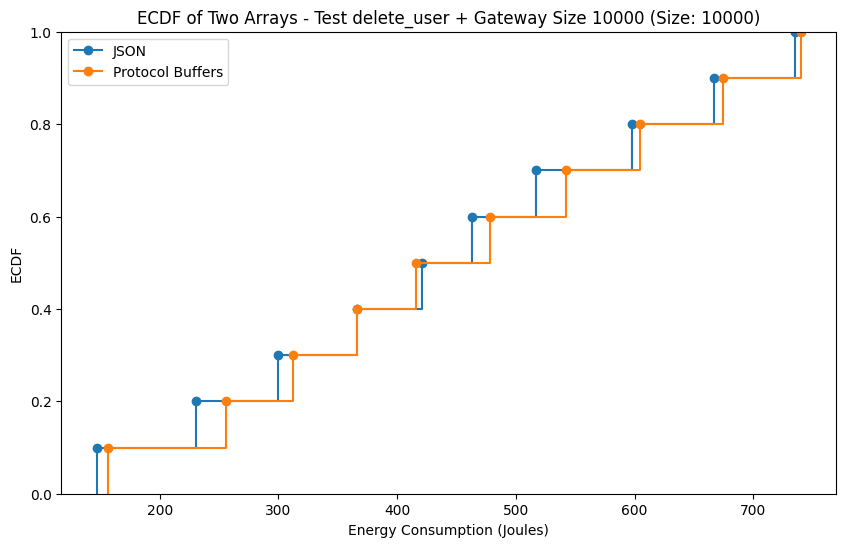

Bootstrap 95% CI for difference: [5.00, 16.22]
delete_user + Gateway - Probability Protocol Buffers < JSON: 0.0%
Bootstrap p-value: 0.0001
Conclusion: Reject H0



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import (
    normaltest,
   ttest_ind,
   shapiro,
   bootstrap
)
def check_normality(data):
    p_value = 1.0
    if len(data) < 3:
        return False, None
    elif len(data) < 20:
        stat, p_value = shapiro(data)
        return p_value > 0.05, (stat, p_value)
    else:
        stat, p_value = normaltest(data)
        return p_value > 0.05, (stat, p_value)

def plot_distributions(values,title,size):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(values[0], label="JSON", fill=True)
    sns.kdeplot(values[1], label="Protocol Buffers", fill=True)
    plt.title("Density Plot of energy consumption - {} (Size: {})".format(title, size))
    plt.xlabel("Energy Consumption (Joules)")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

def plot_ecdf(values, title, size):
    plt.figure(figsize=(10, 6))
    sns.ecdfplot(values[0], label="JSON", marker="o")
    sns.ecdfplot(values[1], label="Protocol Buffers", marker="o")
    plt.title(f"ECDF of Two Arrays - {title} (Size: {size})")
    plt.xlabel("Energy Consumption (Joules)")
    plt.ylabel("ECDF")
    plt.legend()
    plt.show()


def bootstrap_probability(data_dict):
    for test_num, test_data in data_dict.items():
        for size, results in test_data.items():
            plot_ecdf(
                [result.values for result in results],
                f"Test {results[0].name} Size {size}",
                size
            )

            d = (results[1].values, results[0].values,)
            bootstrap_res = bootstrap(
                d,
                statistic=lambda x, y: np.mean(x - y),
                paired=True,
                vectorized=False,
                n_resamples=10000,
            )
            ci_low, ci_high = bootstrap_res.confidence_interval
            print(f"Bootstrap 95% CI for difference: [{ci_low:.2f}, {ci_high:.2f}]")

            bootstrap_diffs = bootstrap_res.bootstrap_distribution
            prob_B_gt_A = np.mean(bootstrap_diffs < 0)
            p_value = np.mean(bootstrap_diffs >= 0)
            print(
                f"{results[0].name} - Probability Protocol Buffers < JSON: {prob_B_gt_A:.1%}"
            )
            print(f"Bootstrap p-value: {p_value:.4f}")
            print(f"Conclusion: {'Reject H0' if p_value < 0.05 else 'Fail to reject H0'}\n")


bootstrap_probability(final_dict)

In [6]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np


# def plot_violin_beeswarm(data_dict, figsize=(10, 6), dpi=100):
#     """
#     Create individual violin+beeswarm plots for each test case and size combination.

#     Parameters:
#     - data_dict: Your dictionary containing the test data
#     - figsize: Tuple (width, height) in inches for each individual plot
#     - dpi: Dots per inch for the output figures
#     """
#     for test_num, test_data in data_dict.items():
#         for size, results in test_data.items():
#             fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

#             # Prepare data for plotting
#             data = []
#             labels = []

#             # Get values from both test runs (0 and 1)
#             for i in range(2):
#                 values = results[i].values
#                 data.append(values)
#                 labels.append("JSON" if i == 0 else "Protocol Buffers")

#             # Create violin plot
#             sns.violinplot(
#                 data=data, ax=ax, inner=None, color="lightgrey", linewidth=1.25
#             )

#             for i, values in enumerate(data):
#                 # Add some jitter to x-axis positions
#                 x = np.random.normal(i, 0.05, size=len(values))
#                 ax.scatter(x, values, alpha=0.5, s=10)

#             ax.set_title(f"{results[0].name} (Requests: {size})")
#             ax.set_ylabel("Energy Consumption (J)")
#             ax.set_xticks(range(len(labels)))
#             ax.set_xticklabels(labels)

#             plt.tight_layout()

#             filename = f"{test_num}_{size}.png"
#             plt.savefig(filename, bbox_inches="tight", dpi=dpi)
#             plt.close(fig)  


# # Example usage:
# # plot_violin_beeswarm(final_dict, figsize=(8, 5), dpi=300)
# plot_violin_beeswarm(final_dict, figsize=(8, 5), dpi=300)

# Generate a code that prints a piramid of dots where i state the number of dots in the bottom row 
def print_piramid(n):
    for i in range(n):
        print("." * (n - i))

print_piramid(5)




